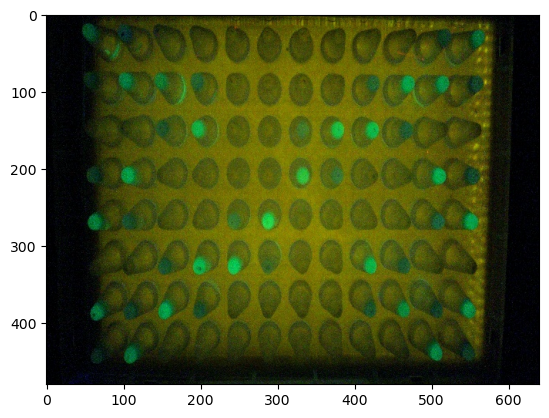

In [66]:
Img = "recent_correct_data/TestPic_3_XRGB8888_Br2_Cst2.jpg"
imageInput = cv2.imread(Img)
plt.imshow(imageInput)

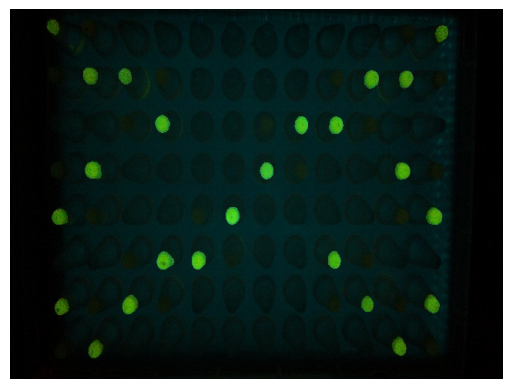

In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
Img = "recent_correct_data/TestPic_3_XRGB8888_Br2_Cst2.jpg"
imageInput = cv2.imread(Img)

# Convert to LAB color space and apply Gaussian blur
imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 0)
lab = cv2.cvtColor(imageInput_blurred, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# Create binary mask based on threshold
threshold_value = 153
_, binary_mask = cv2.threshold(b, threshold_value, 255, cv2.THRESH_BINARY)

# Remove small noise using contour detection
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 200  # Adjust this value to control the noise filter size

# Filter out small contours
for contour in contours:
    if cv2.contourArea(contour) < min_area:
        cv2.drawContours(binary_mask, [contour], -1, 0, -1)  # Fill small areas with black

# Enhance contrast of the filtered binary mask for better visibility
contrast_enhanced = cv2.convertScaleAbs(binary_mask, alpha=2, beta=0)

# Darken the original image
darkened_image = cv2.convertScaleAbs(imageInput, alpha=0.3, beta=0)

# Convert the binary mask to 3 channels for blending
binary_mask_colored = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)

# Use the binary mask to blend original and darkened image
overlayed_image = np.where(binary_mask_colored == 255, imageInput, darkened_image)

# Display the final result
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PySimpleGUI as sg

# Load image
Img = "recent_correct_data/TestPic_3_XRGB8888_Br2_Cst2.jpg"
imageInput = cv2.imread(Img)

# Convert to LAB color space and apply Gaussian blur
imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 0)
lab = cv2.cvtColor(imageInput_blurred, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# Create binary mask based on threshold
threshold_value = 153
_, binary_mask = cv2.threshold(b, threshold_value, 255, cv2.THRESH_BINARY)

# Remove small noise using contour detection
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 200  # Minimum area to keep
for contour in contours:
    if cv2.contourArea(contour) < min_area:
        cv2.drawContours(binary_mask, [contour], -1, 0, -1)

# Darken the original image and apply the mask
darkened_image = cv2.convertScaleAbs(imageInput, alpha=0.3, beta=0)
binary_mask_colored = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
overlayed_image = np.where(binary_mask_colored == 255, imageInput, darkened_image)

# Get image dimensions and define grid positions
height, width, _ = imageInput.shape
vertical_positions = [40, 83, 128, 175, 225, 270, 310, 350, 400, 445, 490, 530, 580]
horizontal_positions = [0, 60, 120, 175, 235, 290, 345, 405, 465]

# Function to draw grid and add labels to each cell
def draw_grid(image, vertical_positions, horizontal_positions):
    for x in vertical_positions:
        cv2.line(image, (x, 0), (x, height), (255, 255, 255), 1)
    for y in horizontal_positions:
        cv2.line(image, (0, y), (width, y), (255, 255, 255), 1)
    
    cell_dict = {}
    grid_height = len(horizontal_positions) - 1
    grid_width = len(vertical_positions) - 1

    for i in range(grid_height):
        for j in range(grid_width):
            label = chr(65 + i) + str(j + 1)
            cell_dict[label] = {
                'x_start': vertical_positions[j],
                'x_end': vertical_positions[j + 1],
                'y_start': horizontal_positions[i],
                'y_end': horizontal_positions[i + 1]
            }
            cv2.putText(image, label, (vertical_positions[j] + 5, horizontal_positions[i] + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return cell_dict

# Draw grid and get coordinates of each cell
cell_dict = draw_grid(overlayed_image, vertical_positions, horizontal_positions)

# Create a binary grid with 1 for positive (white in mask) and 0 for negative cells
binary_grid = {}
min_positive_pixels = 100  # Minimum white pixels in a cell to be considered positive

for cell_name, cell_coords in cell_dict.items():
    # Crop the binary mask for the current cell
    cell_mask = binary_mask[cell_coords['y_start']:cell_coords['y_end'], cell_coords['x_start']:cell_coords['x_end']]
    
    # Count white pixels in the cell
    positive_pixels = cv2.countNonZero(cell_mask)
    
    # Mark as 1 if positive sample is detected, otherwise 0
    binary_grid[cell_name] = 1 if positive_pixels > min_positive_pixels else 0

# Display the binary grid result
print("Binary Grid (1 = Positive, 0 = Negative):")
for row in range(len(horizontal_positions) - 1):
    line = ""
    for col in range(len(vertical_positions) - 1):
        cell_name = chr(65 + row) + str(col + 1)
        line += f"{binary_grid[cell_name]} "
    print(line)

# Convert the image with grid overlay to a format suitable for PySimpleGUI
imageBytes = cv2.imencode('.png', overlayed_image)[1].tobytes()

# Create PySimpleGUI window to display the image
layout = [[sg.Image(data=imageBytes)]]
window = sg.Window('Image with Grid Overlay', layout, finalize=True)

# Event loop to keep the window open
while True:
    event, values = window.read()
    if event == sg.WIN_CLOSED:
        break

window.close()


Binary Grid (1 = Positive, 0 = Negative):
1 0 0 0 0 0 0 0 0 0 0 1 
0 1 1 0 0 0 0 0 0 1 1 0 
0 0 0 1 0 0 0 1 1 0 0 0 
0 1 0 0 0 0 1 0 0 0 1 0 
1 0 0 0 0 1 0 0 0 0 0 1 
0 0 0 1 1 0 0 0 1 0 0 0 
1 0 1 0 0 0 0 0 0 1 0 1 
0 1 0 0 0 0 0 0 0 0 1 0 


2024-10-30 14:16:52.806 python[50787:3940089] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-30 14:16:52.806 python[50787:3940089] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [3]:
## TO JSON format
import json

# Convert the binary grid to a JSON-serializable format
grid_json = json.dumps(binary_grid, indent=4)

# Save JSON to a file
with open("binary_grid.json", "w") as f:
    f.write(grid_json)


In [ ]:
# ----- CLFA -------

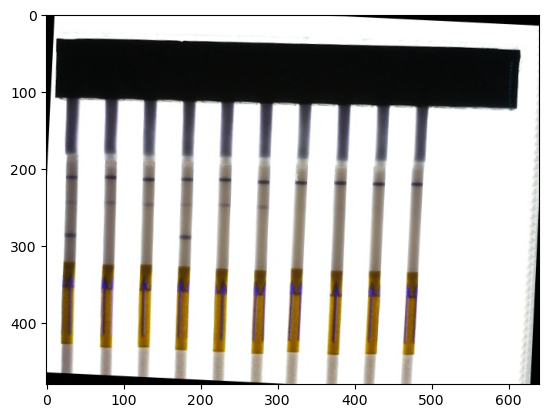

In [103]:
Img = "recent_correct_data/LFA_Br1_Cst1.jpg"
imageInput = cv2.imread(Img)
#imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 0)
lab = cv2.cvtColor(imageInput, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
plt.imshow(rotated_image)

/var/folders/gl/xp97kxjs0ys5qy6zk2zvvp4m0000gn/T/ipykernel_71010/2743232123.py:24: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


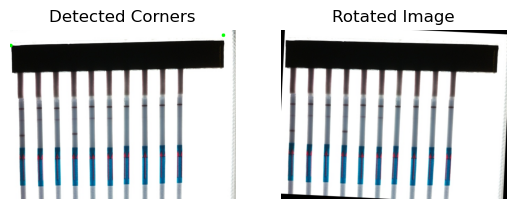

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
Img = "recent_correct_data/LFA_Br1_Cst1.jpg"
imageInput = cv2.imread(Img)

# Convert to grayscale
gray = cv2.cvtColor(imageInput, cv2.COLOR_BGR2GRAY)

# Apply threshold to isolate the black rectangle
_, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Invert to focus on dark areas

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Identify the largest contour, assuming it's the black rectangle
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding rectangle's corners
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Sort corners to find top-left and top-right points
sorted_box = sorted(box, key=lambda x: x[1])  # Sort by y-coordinate to get top corners
top_left, top_right = sorted(sorted_box[:2], key=lambda x: x[0])  # Sort by x-coordinate for left and right

# Calculate angle for rotation
delta_y = top_right[1] - top_left[1]
delta_x = top_right[0] - top_left[0]
angle = np.degrees(np.arctan2(delta_y, delta_x))

# Get image center and rotate to align rectangle horizontally
(h, w) = imageInput.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(imageInput, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

# Display original with detected corners and rotated result
for point in [top_left, top_right]:
    cv2.circle(imageInput, tuple(point), 5, (0, 255, 0), -1)  # Draw detected corner points

# Display the images
plt.subplot(1, 2, 1)
plt.title("Detected Corners")
plt.imshow(cv2.cvtColor(imageInput, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Rotated Image")
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
